# Predicting Helpful Product Reviews: An End-to-End Information Organization System

## Project Overview and Data Collection
As someone who frequently reads product reviews before making purchases, I've always wondered what makes certain reviews more helpful than others. This curiosity, combined with concepts from our Information Organization class, led me to create a machine learning system that predicts whether product reviews will be considered helpful by other users.

I built an end-to-end system that collects and analyzes product reviews to predict their helpfulness. The project started with building a web scraper using Selenium to gather reviews from Best Buy's website, focusing on wireless earbuds and headphones. I chose Best Buy because it has a robust review system where users can vote on review helpfulness, providing natural labels for our machine learning task. Additionally, Best Buy does not require to be authenticated to view product reviews, unlike Amazon, which wants users to be signed-in to view the reviews. This aspect significantly complicated the process of web scraping.

The scraper, implemented as the `BestBuyReviewScraper` class, navigates through product pages and extracts review content, titles, and helpfulness votes. I included random delays between page loads to be respectful of the website's resources. Nevertheless, my goal is not to scrape millions of data points but rather practice building an end-to-end system for scraping data, cleaning, annotating/labeling (manually), and training a machine learning model. The code runs in Google Colab using headless Chrome, making it easily reproducible and platform-independent.

## Data Annotation and Quality

The dataset's relatively modest size (220) and the inherent subjectivity in labeling significantly influenced model performance. I manually labeled reviews as helpful (1) or not helpful (0) based on several criteria:
- Specific product information and features
- Real usage experiences
- Clear pros and cons
- Technical accuracy
- Writing clarity and structure

However, this manual labeling process has several limitations that likely affected model performance:

1. Single annotator bias: As the only annotator, my personal biases and preferences inevitably influenced the labels
2. Limited coverage: The dataset includes reviews for only a specific product category
3. Binary classification limitation: The helpful/not helpful binary might oversimplify the nuanced nature of review helpfulness
4. Temporal consistency: My labeling criteria might have evolved during the annotation process
5. Context dependency: What's helpful for one product might differ for another

## Data Processing and Feature Engineering

The data processing pipeline uses three main classes:
1. `TextPreprocessor`: Handles text normalization and cleaning
2. `EnhancedFeatureEngineering`: Creates features from raw text
3. `ModelEvaluator`: Implements and evaluates machine learning models

The feature engineering draws from our course concepts about how information can be structured and analyzed. I created features that capture:
- Text statistics (length, word count, sentence structure)
- User engagement metrics (helpful/unhelpful votes)
- Content patterns through TF-IDF vectorization
- Writing complexity measures

## Modeling
For the machine learning component, I experimented with both Random Forest and Logistic Regression models, using 5-fold cross-validation to ensure robust evaluation. The Random Forest achieved a mean F1 score of 0.504 (±0.120), while Logistic Regression scored 0.502 (±0.157).

The feature importance analysis revealed interesting patterns. The Random Forest model found review length and writing complexity (average word length) to be strong predictors of helpfulness. This aligns with intuition - longer, more detailed reviews tend to provide more valuable information. The Logistic Regression model, meanwhile, put more emphasis on specific word patterns, suggesting certain types of language correlate with review helpfulness.

The moderate performance metrics should be interpreted in the context of our data limitations. The models' ability to achieve consistent performance above random chance, despite these limitations, suggests that there are indeed learnable patterns in review helpfulness.

In [4]:
# Run this to install Chrome and required packages
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,194 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,627 kB]
Get:13 http://archive.ubuntu.com/ubunt

In [7]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import random
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Chrome options specifically for Colab
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

## Scraping reviews from BestBuy

In [51]:
class BestBuyReviewScraper:
    def __init__(self):
        self.driver = webdriver.Chrome(options=chrome_options)
        self.reviews = []

    def get_reviews_from_page(self):
        """Extract all reviews from current page"""
        print("[EXTRACT] Getting reviews from current page...")
        time.sleep(2)  # Wait for reviews to load

        # Get all review elements
        review_items = self.driver.find_elements(By.CLASS_NAME, "review-item")
        print(f"[EXTRACT] Found {len(review_items)} reviews on page")

        for item in review_items:
            try:
                # Get review content
                content_element = item.find_element(By.CLASS_NAME, "ugc-review-body")
                content = content_element.text.strip()

                # Get title
                title_element = item.find_element(By.CLASS_NAME, "review-title")
                title = title_element.text.strip()

                # Get helpful/unhelpful counts from button text
                helpful = 0
                unhelpful = 0
                try:
                    # Find buttons and extract numbers from text
                    helpful_button = item.find_element(By.CSS_SELECTOR, "button[data-track='Helpful']")
                    unhelpful_button = item.find_element(By.CSS_SELECTOR, "button[data-track='Unhelpful']")

                    # Extract numbers from format "Helpful (X)" and "Unhelpful (X)"
                    helpful = int(helpful_button.text.split('(')[1].split(')')[0])
                    unhelpful = int(unhelpful_button.text.split('(')[1].split(')')[0])

                except Exception as e:
                    print(f"[WARNING] Could not get vote counts: {str(e)}")

                review_data = {
                    'title': title,
                    'content': content,
                    'helpful': helpful,
                    'unhelpful': unhelpful,
                    'product_url': self.driver.current_url
                }

                self.reviews.append(review_data)
                print(f"[EXTRACT] Successfully extracted review with {helpful} helpful and {unhelpful} unhelpful votes")

            except Exception as e:
                print(f"[ERROR] Failed to extract review: {str(e)}")
                continue



    def scrape_reviews(self, url, num_pages=10):
        """Scrape reviews from multiple pages"""
        print(f"\n[SCRAPE] Starting to scrape reviews from {url}")

        try:
            # Load initial page
            self.driver.get(url)
            time.sleep(5)  # wait time for page to load

            for page in range(num_pages):
                print(f"\n[SCRAPE] Processing page {page + 1}")

                # Get reviews from current page
                self.get_reviews_from_page()

                # Random delay between pages
                delay = random.uniform(2, 5)
                print(f"[SCRAPE] Waiting {delay:.1f} seconds...")
                time.sleep(delay)

                try:
                    # Find and click next page button
                    next_button = self.driver.find_element(By.XPATH, '//*[@title="next Page"]')
                    print("[SCRAPE] Next button click: ", next_button)
                    next_button.click()

                    time.sleep(3)  # Wait for next page to load
                except:
                    print("[SCRAPE] No more pages found")
                    break

        except Exception as e:
            print(f"[ERROR] Failed to scrape reviews: {str(e)}")

        finally:
            self.driver.quit()

        return pd.DataFrame(self.reviews)

    def save_to_csv(self, filename='bestbuy_reviews.csv'):
        """Save reviews to CSV file"""
        df = pd.DataFrame(self.reviews)
        df.to_csv(filename, index=False)
        print(f"\n[SAVE] Saved {len(self.reviews)} reviews to {filename}")

        return df


## Running the web scraper

I realize that there is a better way of writing the below code but it was more convenient for me do it iteratively, product by product.

In [27]:
# Run the scraper
#review_url = "https://www.bestbuy.com/site/reviews/sony-wf1000xm5-true-wireless-noise-cancelling-earbuds-black/6546812?variant=A"
#review_url = "https://www.bestbuy.com/site/reviews/apple-airpods-pro-2-wireless-active-noise-cancelling-earbuds-with-hearing-aid-feature-white/6447382?variant=A"
#review_url = "https://www.bestbuy.com/site/reviews/beats-studio-pro-wireless-noise-cancelling-over-the-ear-headphones-black-gold/6501025?variant=A"
#review_url = "https://www.bestbuy.com/site/reviews/beats-studio-buds-totally-wireless-noise-cancelling-earbuds-black/4900915?variant=A"
#review_url = "https://www.bestbuy.com/site/reviews/sony-wf-c700n-truly-wireless-noise-canceling-in-ear-headphones-black/6538256?variant=A"
review_url = "https://www.bestbuy.com/site/reviews/jabra-elite-8-active-gen-2-military-grade-wireless-in-ear-headphones-with-smart-case-black/6582100?variant=A"
scraper = BestBuyReviewScraper()
df = scraper.scrape_reviews(review_url)
df = scraper.save_to_csv()


[SCRAPE] Starting to scrape reviews from https://www.bestbuy.com/site/reviews/jabra-elite-8-active-gen-2-military-grade-wireless-in-ear-headphones-with-smart-case-black/6582100?variant=A

[SCRAPE] Processing page 1
[EXTRACT] Getting reviews from current page...
[EXTRACT] Found 20 reviews on page
[EXTRACT] Successfully extracted review with 0 helpful and 0 unhelpful votes
[EXTRACT] Successfully extracted review with 0 helpful and 0 unhelpful votes
[EXTRACT] Successfully extracted review with 1 helpful and 0 unhelpful votes
[EXTRACT] Successfully extracted review with 0 helpful and 0 unhelpful votes
[EXTRACT] Successfully extracted review with 1 helpful and 0 unhelpful votes
[EXTRACT] Successfully extracted review with 0 helpful and 0 unhelpful votes
[EXTRACT] Successfully extracted review with 1 helpful and 1 unhelpful votes
[EXTRACT] Successfully extracted review with 0 helpful and 0 unhelpful votes
[EXTRACT] Successfully extracted review with 0 helpful and 0 unhelpful votes
[EXTRACT]

## Combining the scraped data into a single file

In [28]:
input_dir = '/content/raw_data'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

dfs = []

# Loop through each CSV file and read it into a DataFrame
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(input_dir, csv_file))
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv('/content/data/combined.csv', index=False)

## Duplicates happen, let's remove them in the below cell

In [29]:
# Load the combined CSV file into a DataFrame
df = pd.read_csv('/content/data/combined.csv')

duplicates = df[df.duplicated(subset=['content'], keep=False)]

df_no_duplicates = df.drop_duplicates(subset=['content'], keep='first')

df_no_duplicates.to_csv('/content/data/combined_no_duplicates.csv', index=False)

## Preprocessing and Feature Engineering Class

In [52]:
class TextPreprocessor:
    def __init__(self):
        nltk.download('punkt', quiet=True)
        nltk.download('punkt_tab', quiet=True)
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = str(text).lower()
        # Remove special characters but keep single quotes for contractions
        text = re.sub(r'[^a-zA-Z\'\s]', '', text)
        # Remove standalone single quotes
        text = re.sub(r'\s+\'\s+', ' ', text)
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
        return ' '.join(tokens)

class EnhancedFeatureEngineering:
    def __init__(self):
        self.text_preprocessor = TextPreprocessor()
        self.vectorizer = TfidfVectorizer(
            max_features=1000,
            ngram_range=(1, 2),  # Include bigrams
            min_df=2,  # Minimum document frequency
            max_df=0.95  # Maximum document frequency
        )
        self.scaler = StandardScaler()

    def create_features(self, df):
        # Basic text features
        features = pd.DataFrame()
        features['title_length'] = df['title'].str.len()
        features['content_length'] = df['content'].str.len()
        features['word_count'] = df['content'].str.split().str.len()

        # Engagement features
        features['total_votes'] = df['helpful'] + df['unhelpful']
        features['helpful_ratio'] = df['helpful'] / (features['total_votes'] + 1)

        # Advanced text features
        features['avg_word_length'] = df['content'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
        features['sentence_count'] = df['content'].str.count('[.!?]+')
        features['exclamation_count'] = df['content'].str.count('!')

        # Clean and vectorize text
        cleaned_content = df['content'].apply(self.text_preprocessor.clean_text)
        text_features = self.vectorizer.fit_transform(cleaned_content)

        # Scale numerical features
        numerical_features = self.scaler.fit_transform(features)
        features = pd.DataFrame(numerical_features, columns=features.columns)

        # Combine with text features
        text_feature_names = [f'tfidf_{i}' for i in range(text_features.shape[1])]
        text_features_df = pd.DataFrame(text_features.toarray(), columns=text_feature_names)

        return pd.concat([features, text_features_df], axis=1)

## Model Evaluation

In [53]:
class ModelEvaluator:
    def __init__(self):
        self.models = {
            'random_forest': RandomForestClassifier(
                n_estimators=20,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42
            ),
            'logistic_regression': LogisticRegression(
                C=1.0,
                class_weight='balanced',
                max_iter=1000,
                random_state=42
            )
        }

    def evaluate_models(self, X, y):
        results = {}
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for name, model in self.models.items():
            # Perform cross-validation
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')

            # Fit model on full dataset for feature importance
            model.fit(X, y)

            # Store results
            results[name] = {
                'cv_scores': cv_scores,
                'mean_cv_score': cv_scores.mean(),
                'std_cv_score': cv_scores.std()
            }

            # Get feature importance for Random Forest
            if name == 'random_forest':
                feature_importance = pd.DataFrame({
                    'feature': X.columns,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                results[name]['feature_importance'] = feature_importance

            # Get coefficients for Logistic Regression
            if name == 'logistic_regression':
                coefficients = pd.DataFrame({
                    'feature': X.columns,
                    'coefficient': abs(model.coef_[0])
                }).sort_values('coefficient', ascending=False)
                results[name]['feature_importance'] = coefficients

        return results

## Analysis

In [56]:
class ReviewAnalyzer:
    def __init__(self):
        self.feature_engineering = EnhancedFeatureEngineering()
        self.model_evaluator = ModelEvaluator()

    def analyze(self, df):
        # Create features
        X = self.feature_engineering.create_features(df)
        y = df['target']

        # Evaluate models
        results = self.model_evaluator.evaluate_models(X, y)

        # Print results
        self.print_results(results)

        # Plot insights
        self.plot_insights(results)

    def print_results(self, results):
        for model_name, result in results.items():
            print(f"\n{model_name.upper()} RESULTS:")
            print(f"Mean CV Score: {result['mean_cv_score']:.3f} (+/- {result['std_cv_score']*2:.3f})")
            print("\nTop 10 Important Features:")
            print(result['feature_importance'].head(10))

    def plot_insights(self, results):
        plt.figure(figsize=(15, 5))

        # Plot cross validation scores
        plt.subplot(131)
        cv_scores = [results[model]['cv_scores'] for model in results.keys()]
        plt.boxplot(cv_scores, labels=list(results.keys()))
        plt.title('Cross-Validation Scores Comparison')
        plt.ylabel('F1 Score')

        # Plot Random Forest feature importance
        plt.subplot(132)
        rf_features = results['random_forest']['feature_importance'].head(5)
        plt.barh(rf_features['feature'], rf_features['importance'])
        plt.title('Top 5 Important Features (Random Forest)')

        # Plot logistic regression feature importance
        plt.subplot(133)
        lr_features = results['logistic_regression']['feature_importance'].head(5)
        plt.barh(lr_features['feature'], lr_features['coefficient'])
        plt.title('Top 5 Features (Logistic Regression)')

        plt.tight_layout()
        plt.show()

## Running all the above code below

The `ReviewAnalyzer` class uses all other classes internally.


RANDOM_FOREST RESULTS:
Mean CV Score: 0.504 (+/- 0.120)

Top 10 Important Features:
             feature  importance
2         word_count    0.048130
102         tfidf_94    0.035626
496        tfidf_488    0.016425
5    avg_word_length    0.012712
489        tfidf_481    0.012217
0       title_length    0.011890
103         tfidf_95    0.011222
6     sentence_count    0.011219
894        tfidf_886    0.011115
924        tfidf_916    0.010937

LOGISTIC_REGRESSION RESULTS:
Mean CV Score: 0.502 (+/- 0.157)

Top 10 Important Features:
       feature  coefficient
924  tfidf_916     0.878186
102   tfidf_94     0.862888
399  tfidf_391     0.721259
985  tfidf_977     0.653249
159  tfidf_151     0.570720
814  tfidf_806     0.569718
563  tfidf_555     0.555434
574  tfidf_566     0.552528
699  tfidf_691     0.551789
49    tfidf_41     0.510817


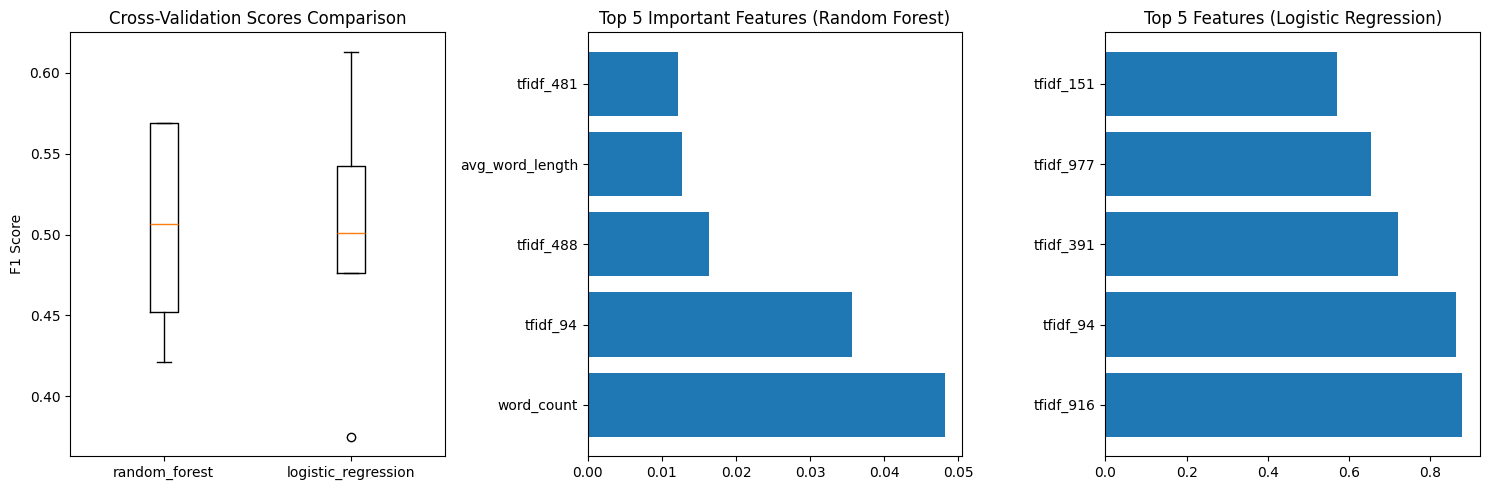

In [55]:
df = pd.read_csv('/content/data/reviews-labeled.csv')

# Initialize and run analysis
analyzer = ReviewAnalyzer()
analyzer.analyze(df)